### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Zimo Peng`

**Student ID:**     `1143743`


This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [1]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

[[ -1   2   1 ...  -3  -1  -1]
 [  3  -3   0 ...   0   2   0]
 [ -1   2   1 ...  -2  -1  -1]
 ...
 [ -8  10   1 ...  12  13 -10]
 [ -3   1   3 ...   7   4 -13]
 [ -4   0   2 ...   5   3 -14]]


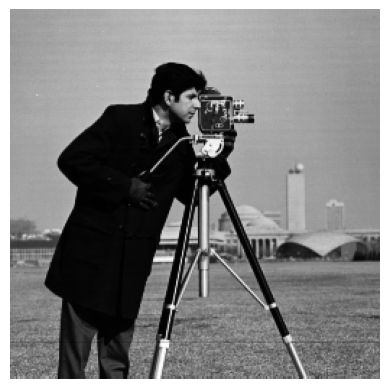

In [120]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])

camera_img = cv2.imread(os.path.join('./', "cameraman.png"),cv2.IMREAD_GRAYSCALE)

def do_laplacian(n, camera_img, kernel):
    layers = dict()
    size = 0
    for i in range(n):
        if (i < n - 1):
            filtered = cv2.filter2D(src = camera_img, ddepth = -1, kernel = kernel)
            down = filtered[::2, ::2]
            up = np.zeros((filtered.shape[0], filtered.shape[1]))
            up[::2, ::2] = down
            up = up.astype(np.uint8)
            filtered_u = cv2.filter2D(up, -1, kernel*4)
            layers[size] = cv2.subtract(camera_img, filtered_u, dtype=cv2.CV_16S)
            size += 1     
            camera_img = down
        else:
            layers[size] = camera_img
    return layers

def recreation(layers):
    size = len(layers)
    img = layers[size-1]
    for i in range(size-1)[::-1]:
        up = np.array(np.zeros((layers[i].shape[0], layers[i].shape[1])))
        up[::2, ::2] = img
        up = up.astype(np.uint8)
        filtered_u = cv2.filter2D(src = up, ddepth = -1, kernel = 4*kernel)
        img = filtered_u + layers[i]
    return img  
            
layers = do_laplacian(5, camera_img, kernel)
print(layers[0])
img = recreation(layers)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()



### 2. Quantization and compression

### 3. Evaluation in the frequency domain

[[-6.848  9.84   9.84  ... -6.848 -6.848 -6.848]
 [ 9.84  -6.848 -6.848 ... -6.848  9.84  -6.848]
 [-6.848  9.84   9.84  ... -6.848 -6.848 -6.848]
 ...
 [-6.848  9.84   9.84  ...  9.84   9.84  -6.848]
 [-6.848  9.84   9.84  ...  9.84   9.84  -6.848]
 [-6.848 -6.848  9.84  ...  9.84   9.84  -6.848]]


C:\Users\zimop\AppData\Local\Temp\ipykernel_11624\3139329359.py:25: RuntimeWarning: Mean of empty slice.
  avg_dicts = {binn: (sorted_layer[(sorted_layer>=binn[0]) & (sorted_layer <= binn[1])]).mean() for binn in new_bins}


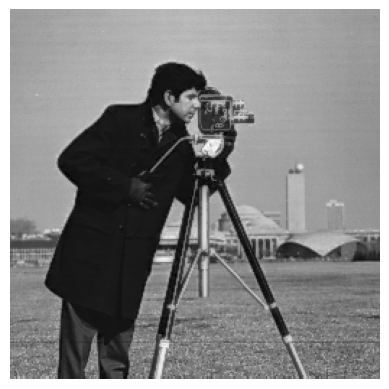

In [134]:
def quantization(layer, bits):
    picture = layer
    picture = picture.astype(np.float16)
    total_bins = 2**bits
    height = layer.shape[0]
    width = layer.shape[1]
    if total_bins > (height*width):
        print("too many bins")
        return
    layer = layer.ravel()
    layer = layer.astype(np.float16)
    sorted_layer = np.sort(layer)
    layer = sorted_layer.reshape(total_bins, -1)
    
    bins = [[x[0], x[-1]] for x in layer] 
    prev_bin = -1
    new_bins = []
    for binn in bins:
        x = binn[0]
        y = binn[1]
        if x == prev_bin:
            x = x+1
        new_bins.append((x, y))
        prev_bin = y
    avg_dicts = {binn: (sorted_layer[(sorted_layer>=binn[0]) & (sorted_layer <= binn[1])]).mean() for binn in new_bins}
    new_picture = np.array([put_bins(avg_dicts, row) for row in picture])
    return (new_picture)

    
     
    
def put_bins(bins,row):
    size = 0
    for value in row:
        for binn in bins.keys():
            if (value >= binn[0]) & (value <= binn[1]):
                row[size] = bins[binn]
        size += 1
    return row
    
##layers = np.arange(0, 16).reshape(4,4)
##layers = np.append(layers, [[1,1,2,3]], axis = 0)
print(quantization(layers[0], 1))
new_layers = {0: quantization(layers[0], 4), 1: quantization(layers[1], 5), 2: layers[2], 3: layers[3], 4: layers[4]}
img = recreation(new_layers)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()